For anmiation of GOL in python https://www.geeksforgeeks.org/conways-game-life-python-implementation/

# Implementing GOL

In [2]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# setting up the values for the grid
ON = 255
OFF = 0
vals = [ON, OFF]
 
def randomGrid(N):
 
    """returns a grid of NxN random values"""
    return np.random.choice(vals, N*N, p=[0.2, 0.8]).reshape(N, N)

def update(steps,grid, N):
 
    # copy grid since we require 8 neighbors
    # for calculation and we go line by line
  
    for s in range(steps):
        newGrid = grid.copy()
        for i in range(N):
            for j in range(N):

                # compute 8-neghbor sum
                # using toroidal boundary conditions - x and y wrap around
                # so that the simulaton takes place on a toroidal surface.
                total = int((grid[i, (j-1)%N] + grid[i, (j+1)%N] +
                             grid[(i-1)%N, j] + grid[(i+1)%N, j] +
                             grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] +
                             grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N])/255)
                
                # apply Conway's rules
                if grid[i, j]  == ON:
                    if (total < 2) or (total > 3):
                        newGrid[i, j] = OFF
                else:
                    if total == 3:
                        newGrid[i, j] = ON

        # update data
        grid[:] = newGrid[:]
    return(grid[:])

def timeseries(numofsteps,grid,N):
    series= []
    series.append(grid.copy())
    for s in range(numofsteps):
        update(1,grid,N)
        series.append(grid.copy())
    return(series)


    

In [3]:
grid=np.array([[255,0,0],[0,255,0],[255,0,0]])
print(grid)
update(1,grid,3)

[[255   0   0]
 [  0 255   0]
 [255   0   0]]


array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]])

In [4]:
N=30
steps=1
grid = randomGrid(N)
np.save("./timeseriesdata",timeseries(steps,grid,N))

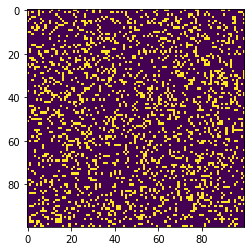

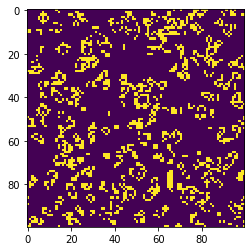

In [5]:
N=100
fig, ax = plt.subplots()
grid=randomGrid(N)
#grid=np.array([[255,0,0,0,0],[0,0,255,0,0],[0,255,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
img = ax.imshow(grid, interpolation='nearest')
for i in range(1):
    fig, ax = plt.subplots()
    update(10,grid,N)
    ax.imshow(grid, interpolation='nearest')

# Implementing some learning
See this for reference https://arxiv.org/pdf/1807.10300.pdf  
Tensorflow intro: https://www.tensorflow.org/tutorials/quickstart/beginner  
Loss functions: https://keras.io/api/losses/  
2D Convolutional layer: https://keras.io/api/layers/convolution_layers/convolution2d/  
for periodic padding see: https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding  

Input: 3x3 layer  
Then either convolutional layers, or dense layers (or both).  
Output should by the probabilities of the central cell being ON or OFF  
i.e. last layer output of size 2 with 'softmax' activation  

In [11]:
#generating a training and test dataset
import tensorflow as tf

#defining the learning model
numofgrids=50000
dimx=5
dimy=5
t=1
middle=(np.floor(dimx/2),np.floor(dimy/2))
(x_train,y_train)=([],[])
for i in range(numofgrids):
    grid=randomGrid(dimx)
    x_train.append(grid[int(np.floor(dimx/2)-1):int(np.floor(dimx/2)+2),int(np.floor(dimy/2)-1):int(np.floor(dimy/2)+2)].copy())
    grid_=update(t,grid,dimy).copy()
    y_train.append([grid_[int(np.floor(dimx/2)),int(np.floor(dimx/2))].copy(), 255-grid_[int(np.floor(dimx/2)),int(np.floor(dimx/2))].copy()])
print(x_train[0])
print(y_train[0])
x_train =np.array(x_train).reshape(numofgrids,3,3,1)/255
y_train =np.array(y_train).reshape(numofgrids,2)/255

print(x_train[0])
print(y_train[0])

[[  0   0   0]
 [255   0   0]
 [  0   0   0]]
[0, 255]
[[[0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]]]
[0. 1.]


In [7]:
np.sum(y_train,axis=0)/50000

array([0.2033, 0.7967])

In [1]:
x=tf.random.normal((numofgrids,3,3,1))
y=tf.keras.layers.Conv2D(9,3,
        input_shape=(3,3,1),
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation=None,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None)(x)
print(y.shape)

modelB = tf.keras.models.Sequential([
    
    tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(100),
         tf.keras.layers.Dense(100),
         tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(2,activation="softmax")
])

modelA = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(9,3,
        input_shape=(3,3,1),
        strides=(1, 1),
        padding="same",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation=None,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None),
    tf.keras.layers.Conv2D(9,3,
        input_shape=(50000,1,1,9),
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation=None,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None),

    tf.keras.layers.Dense(2,activation="softmax")
])



#print(tf.nn.softmax(predictions).numpy())
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
predictions = modelA(x_train).numpy()
loss_fn(y_train, predictions).numpy()
modelA.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[tf.keras.metrics.BinaryAccuracy()])
modelA.fit(x_train, y_train, epochs=5)
predictions = modelA(x_train).numpy()
predictions[0]

NameError: name 'tf' is not defined

In [5]:
print(modelA(x_train[1:3]).numpy())
print(x_train[1:3].reshape(2,3,3))

[[0.8901023  0.10989771]
 [0.27429867 0.72570133]]
[[[1. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 0. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]]


In [6]:
grid=np.array([[1,0,0],[0,0,0],[1,0,1]])
print(grid)
modelA(grid.reshape(1,3,3,1)).numpy()



[[1 0 0]
 [0 0 0]
 [1 0 1]]


array([[0.6196021 , 0.38039795]], dtype=float32)

In [7]:
np.floor(3.4)

3.0

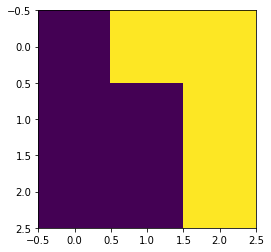

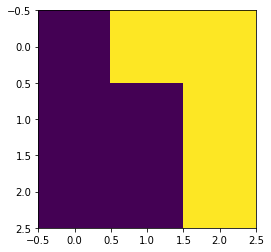

In [8]:

N=3
time=1
grid=randomGrid(N)

gridev=timeseries(time,grid,N)
for t in range(time+1):
    fig, ax = plt.subplots()
    fig=ax.imshow(gridev[t], interpolation='nearest')

[[255   0   0]
 [  0 255   0]
 [255   0   0]]
[[255 255 255]
 [255 255 255]
 [255 255 255]]


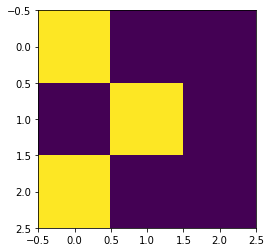

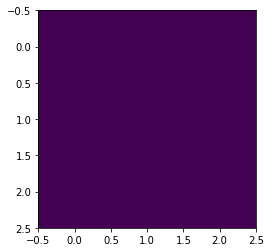

In [9]:

N=3
time=1
grid=np.array([[255,0,0],[0,255,0],[255,0,0]])
#grid=np.array([[0,0,0,0,0],[0,255,0,0,0],[0,0,255,0,0],[0,255,0,0,0],[0,0,0,0,0]])
gridev=timeseries(time,grid,N)

for t in range(time+1):
    print(gridev[t])
    fig, ax = plt.subplots()
    fig=ax.imshow(gridev[t], interpolation='none')

In [10]:
np.zeros((5,5))[int(np.floor(5/2)-1):int(np.floor(5/2)+2),int(np.floor(5/2)-1):int(np.floor(5/2)+2)]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [11]:
int(np.floor(5/2)-1),int(np.floor(5/2)+2)

(1, 4)

In [12]:
np.zeros((5,5))[1:4,1:4]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [13]:
dimx=5
dimy=5
t=1
(x_train,y_train)=([],[])
grid=randomGrid(dimx)
print(grid)
x_train.append(grid[int(np.floor(dimx/2)-1):int(np.floor(dimx/2)+2),int(np.floor(dimy/2)-1):int(np.floor(dimy/2)+2)].copy())
grid_=update(t,grid,dimy).copy()
print(grid_)
y_train.append(grid_[int(np.floor(dimx/2)),int(np.floor(dimx/2))].copy())
print(x_train)
print(y_train)

[[  0   0 255   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0 255   0   0   0]
 [255   0   0   0 255]]
[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [255   0   0   0   0]
 [255 255   0   0   0]]
[array([[  0,   0,   0],
       [  0,   0,   0],
       [255,   0,   0]])]
[0]
